Use the [updated version now on github](https://colab.research.google.com/github/hgbrian/biocolabs/blob/master/DiffDock.ipynb).

# DiffDock
Dock a PDB files and a SMILES with [DiffDock](https://github.com/gcorso/DiffDock).

Select Runtime / Run all to run an example PDB file and SMILES.

v2 improvements:
- works on proteins >1000 aas (with flag added to extract.py)
- works on standard GPU (by reducing batch size from 10 to 6)
- works with AlphaFold ids (AF-...) as well as PDB ids
- works with comma-delimited PDB_ids and/or SMILES
- runs smina to generate affinities (as DiffDock posed, or with smina minimization)
- shows results in a py3DMol view

v3:
- fix py3dmol incompatibility
- downgrade pytorch since the colab version takes forever to install pytorch_geometric (no binary so it has to compile)
THIS MEANS YOU HAVE TO RUN ALL TWICE!

v4:
- replace smina with the more accurate gnina
- remove the annoying run twice thing now there is a binary

colab by [@btnaughton](https://twitter.com/btnaughton)

In [ ]:
#@title PDB + SMILES input

PDB_id = '1M17' #@param {type:"string"}
SMILES_or_pubchem_id = 'COc1cc2c(cc1OC)c(ncn2)Nc3ccc(c(c3)Cl)F' #@param {type:"string"}

#@markdown Download a tar file containing all results?
download_results = True #@param {type:"boolean"}

In [ ]:
# The default version of colab takes forever to install pytorch_geometric
# For now, downgrade (which requires restarting runtime :( )
import os
import torch

# Target PyTorch version for better PyG compatibility
TARGET_TORCH_VERSION = "2.2.0"

if not hasattr(torch, '__version__') or torch.__version__.split('+')[0] != TARGET_TORCH_VERSION:
    print(f"torch version is not {TARGET_TORCH_VERSION}, uninstalling current torch...")
    !pip uninstall torch torchaudio torchdata torchtext torchvision fastai --y
    print(f"Installing torch=={TARGET_TORCH_VERSION}...")
    !pip install torch=={TARGET_TORCH_VERSION} --index-url https://download.pytorch.org/whl/cu121
    print("Restarting runtime to apply torch version change...")
    os.kill(os.getpid(), 9)
else:
    print(f"Current torch version: {torch.__version__}")

Current torch version: 2.2.0+cu121


In [ ]:
import os
import requests
import time
from random import random

def download_pdb_file(pdb_id: str) -> str:
    """Download pdb file as a string from rcsb.org"""
    PDB_DIR ="/tmp/pdb/"
    os.makedirs(PDB_DIR, exist_ok=True)

    # url or pdb_id
    if pdb_id.startswith('http'):
        url = pdb_id
        filename = url.split('/')[-1]
    elif pdb_id.endswith(".pdb"):
        return pdb_id
    else:
        if pdb_id.startswith("AF"):
            url = f"https://alphafold.ebi.ac.uk/files/{pdb_id}-model_v3.pdb"
        else:
            url = f"http://files.rcsb.org/view/{pdb_id}.pdb"
        filename = f'{pdb_id}.pdb'

    cache_path = os.path.join(PDB_DIR, filename)
    if os.path.exists(cache_path):
        return cache_path

    pdb_req = requests.get(url)
    pdb_req.raise_for_status()
    open(cache_path, 'w').write(pdb_req.text)
    return cache_path

def download_smiles_str(pubchem_id: str, retries:int = 2) -> str:
    """Given a pubchem id, get a smiles string"""
    while True:
        req = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/{pubchem_id}/property/CanonicalSMILES/CSV")
        smiles_url_csv = req.text if req.status_code == 200 else None
        if smiles_url_csv is not None:
            break
        if retries == 0:
            return None
        time.sleep(1+random())
        retries -= 1

    return smiles_url_csv.splitlines()[1].split(',')[1].strip('"').strip("'") if smiles_url_csv is not None else None

In [ ]:
if not PDB_id or not SMILES_or_pubchem_id:
    PDB_id = "6agt"
    SMILES_or_pubchem_id = "COc(cc1)ccc1C#N"
    print(f"No input supplied. Using example data: {PDB_id} and {SMILES_or_pubchem_id}")

# to run many PDB+smiles at once, fill in a list of PDB_files and smiles here...
pdb_files = [download_pdb_file(_PDB_id) for _PDB_id in PDB_id.split(",")]
smiless = [download_smiles_str(_SMILES_or_pubchem_id) if str(_SMILES_or_pubchem_id).isnumeric() else _SMILES_or_pubchem_id
           for _SMILES_or_pubchem_id in SMILES_or_pubchem_id.split(',') ]

with open("/tmp/input_protein_ligand.csv", 'w') as out:
    out.write("protein_path,ligand\n")
    for pdb_file in pdb_files:
        for smiles in smiless:
            out.write(f"{pdb_file},{smiles}\n")

In [ ]:
# clear out old results if running multiple times -- hopefully they have been downloaded already
!rm -rf /content/DiffDock/results

## Install prerequisites

In [ ]:
!pip install ipython-autotime --quiet
%load_ext autotime

time: 220 µs (started: 2026-01-11 13:13:53 +00:00)


In [ ]:
if not os.path.exists("/content/DiffDock"):
    %cd /content
    !git clone https://github.com/gcorso/DiffDock.git
    %cd /content/DiffDock
    !git checkout a6c5275 # remove/update for more up to date code

time: 496 µs (started: 2026-01-11 13:13:53 +00:00)


In [ ]:
try:
    import biopandas
except:
    # !pip install pyg==0.7.1 --quiet # Removed conflicting old pyg version
    !pip install pyyaml==6.0 --quiet
    !pip install scipy==1.7.3 --quiet
    !pip install networkx==2.6.3 --quiet
    !pip install biopython==1.79 --quiet
    !pip install rdkit-pypi==2022.03.5 --quiet
    !pip install e3nn==0.5.0 --quiet
    !pip install spyrmsd==0.5.2 --quiet
    !pip install pandas==1.5.3 --quiet
    !pip install biopandas==0.4.1 --quiet

time: 4.28 ms (started: 2026-01-11 13:13:53 +00:00)


In [ ]:
import torch
import os

print(f"Current torch version: {torch.__version__}")
print(f"Current CUDA version from torch: {torch.version.cuda}")

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_VERSION_BASE = format_pytorch_version(torch.__version__)
# Explicitly set CUDA_VERSION for PyG wheels to 'cu121'
# PyG often provides wheels for specific CUDA versions (e.g., cu121) that are forward-compatible with newer CUDA 12.x.
# If this fails, 'cu118' could be another option, but cu121 is more likely for torch 2.x and CUDA 12.x.
CUDA_VERSION_FOR_PYG_WHEELS = 'cu121' if torch.cuda.is_available() else 'cpu'

print(f"Attempting to install PyG dependencies for torch-{TORCH_VERSION_BASE}+{CUDA_VERSION_FOR_PYG_WHEELS}")

# Uninstall potentially problematic previous installations first
!pip uninstall -y torch_geometric torch-scatter torch-sparse torch-cluster --quiet

# Install PyTorch Geometric and its core dependencies in one go using the specified CUDA_VERSION_FOR_PYG_WHEELS
!pip install torch_geometric torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-{TORCH_VERSION_BASE}+{CUDA_VERSION_FOR_PYG_WHEELS}.html --quiet

# Now try importing torch_geometric to confirm
try:
    import torch_geometric
    print("torch_geometric and its dependencies are installed.")
except ModuleNotFoundError:
    print("torch_geometric or its dependencies still not found. Please restart runtime.")

Current torch version: 2.2.0+cu121
Current CUDA version from torch: 12.1
Attempting to install PyG dependencies for torch-2.2.0+cu121
torch_geometric and its dependencies are installed.
time: 16.9 s (started: 2026-01-11 13:13:53 +00:00)


## Install ESM and prepare PDB file for ESM

In [ ]:
if not os.path.exists("/content/DiffDock/esm"):
    %cd /content/DiffDock
    !git clone https://github.com/facebookresearch/esm
    %cd /content/DiffDock/esm
    !git checkout ca8a710 # remove/update for more up to date code
    !sudo pip install -e .
    %cd /content/DiffDock

time: 566 µs (started: 2026-01-11 13:14:09 +00:00)


In [ ]:
%cd /content/DiffDock
!python datasets/esm_embedding_preparation.py --protein_ligand_csv /tmp/input_protein_ligand.csv --out_file data/prepared_for_esm.fasta

/content/DiffDock
100% 1/1 [00:00<00:00, 16.14it/s]
time: 910 ms (started: 2026-01-11 13:14:09 +00:00)


In [ ]:
%cd /content/DiffDock
%env HOME=esm/model_weights
%env PYTHONPATH=$PYTHONPATH:/content/DiffDock/esm
!python /content/DiffDock/esm/scripts/extract.py esm2_t33_650M_UR50D data/prepared_for_esm.fasta data/esm2_output --repr_layers 33 --include per_tok --truncation_seq_length 30000

/content/DiffDock
env: HOME=esm/model_weights
env: PYTHONPATH=$PYTHONPATH:/content/DiffDock/esm
Transferred model to GPU
Read data/prepared_for_esm.fasta with 1 sequences
Processing 1 of 1 batches (1 sequences)
time: 21.8 s (started: 2026-01-11 13:14:10 +00:00)


## Run DiffDock

In [ ]:
import os
%cd /content/DiffDock
%env PYTHONPATH=$PYTHONPATH:$(pwd)
!touch datasets/__init__.py
!python inference.py --protein_ligand_csv /tmp/input_protein_ligand.csv --out_dir results/user_predictions_small --inference_steps 20 --samples_per_complex 40 --batch_size 6

/content/DiffDock
env: PYTHONPATH=$PYTHONPATH:$(pwd)
100% 201/201 [01:01<00:00,  3.25it/s]
100% 201/201 [01:24<00:00,  2.37it/s]
/content/DiffDock/utils/torus.py:38: RuntimeWarning: invalid value encountered in divide
  score_ = grad(x, sigma[:, None], N=100) / p_
Reading molecules and generating local structures with RDKit
100% 1/1 [00:00<00:00, 16.64it/s]
Reading language model embeddings.
Generating graphs for ligands and proteins
loading complexes: 100% 1/1 [00:00<00:00,  2.82it/s]
loading data from memory:  data/cache_torsion/limit0_INDEX_maxLigSizeNone_H0_recRad15.0_recMax24_esmEmbeddings2620842630/heterographs.pkl
Number of complexes:  1
radius protein: mean 58.81404495239258, std 0.0, max 58.81404495239258
radius molecule: mean 6.590351104736328, std 0.0, max 6.590351104736328
distance protein-mol: mean 64.12349700927734, std 0.0, max 64.12349700927734
rmsd matching: mean 0.0, std 0.0, max 0
HAPPENING | confidence model uses different type of graphs than the score model. Loadin

# Post-process and download results

In [ ]:
%cd /content/DiffDock
!wget https://sourceforge.net/projects/smina/files/smina.static/download -O smina && chmod +x smina
!wget https://github.com/gnina/gnina/releases/download/v1.0.3/gnina -O gnina && chmod +x gnina

/content/DiffDock
--2026-01-11 13:25:26--  https://sourceforge.net/projects/smina/files/smina.static/download
Resolving sourceforge.net (sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Connecting to sourceforge.net (sourceforge.net)|104.18.12.149|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABpY6THp8tEdOrSNBrKVi2X3vUy1CzcAyZUvxaUulHHMjIAgJRZJt1zCxO0XeVmeTKQtmfqaIzEO18mBCE3Rwb8uWRY5w%3D%3D&use_mirror=sf-west-interserver-2&r= [following]
--2026-01-11 13:25:27--  https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABpY6THp8tEdOrSNBrKVi2X3vUy1CzcAyZUvxaUulHHMjIAgJRZJt1zCxO0XeVmeTKQtmfqaIzEO18mBCE3Rwb8uWRY5w%3D%3D&use_mirror=sf-west-interserver-2&r=
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:c95, ...
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|104.18.12.

In [ ]:
import re
import pandas as pd
from glob import glob
from shlex import quote
from datetime import datetime
from tqdm.auto import tqdm
from google.colab import files

%cd /content/DiffDock/results/user_predictions_small
results_dirs = glob("./index*")

rows = []
for results_dir in tqdm(results_dirs, desc="runs"):
    results_pdb_file = "/tmp/pdb/" + re.findall("tmp-pdb-(.+\.pdb)", results_dir)[0]
    results_smiles = re.findall("pdb_+(.+)", results_dir)[0]
    results_sdfs = [os.path.join(results_dir, f) for f in os.listdir(results_dir) if "confidence" in f and f.endswith(".sdf")]

    results_pdb_file_no_hetatms = f"{results_pdb_file}_nohet.pdb"
    !grep -v "^HETATM" {results_pdb_file} > {results_pdb_file_no_hetatms}
    !cp {results_pdb_file} .

    for results_sdf in tqdm(results_sdfs, leave=False, desc="files"):
        confidence = re.findall("confidence([\-\.\d]+)\.sdf", results_sdf)[0]

        scored_stdout = !/content/DiffDock/gnina --score_only -r "{results_pdb_file_no_hetatms}" -l "{results_sdf}"
        scored_affinity = re.findall("Affinity:\s*([\-\.\d+]+)", '\n'.join(scored_stdout))[0]
        minimized_stdout = !/content/DiffDock/gnina --local_only --minimize -r "{results_pdb_file_no_hetatms}" -l "{results_sdf}" --autobox_ligand "{results_sdf}" --autobox_add 2
        minimized_affinity = re.findall("Affinity:\s*([\-\.\d+]+)", '\n'.join(minimized_stdout))[0]

        rows.append((results_pdb_file.split('/')[-1], results_smiles, float(confidence), float(scored_affinity), float(minimized_affinity), results_sdf))

#
# create dataframe, tar file and download
#
df_results = pd.DataFrame(rows, columns=["pdb_file", "smiles", "diffdock_confidence", "gnina_scored_affinity", "gnina_minimized_affinity", "sdf_file"])
df_results_tsv = "df_diffdock_results.tsv"
df_results.to_csv(df_results_tsv, sep='\t', index=None)

out_pdbs = ' '.join(set(df_results.pdb_file.apply(quote)))
out_sdfs = ' '.join(df_results.sdf_file.apply(quote))

if download_results:
    tarname = f"diffdock_{datetime.now().isoformat()[2:10].replace('-','')}"
    _ = !tar cvf {tarname}.tar --transform 's,^,{tarname}/,' --transform 's,\./,,' {out_pdbs} {out_sdfs} {df_results_tsv}

    files.download(f"{tarname}.tar")

/content/DiffDock/results/user_predictions_small


<>:14: SyntaxWarning: invalid escape sequence '\.'
<>:23: SyntaxWarning: invalid escape sequence '\-'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\.'
<>:23: SyntaxWarning: invalid escape sequence '\-'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1867575909.py:14: SyntaxWarning: invalid escape sequence '\.'
  results_pdb_file = "/tmp/pdb/" + re.findall("tmp-pdb-(.+\.pdb)", results_dir)[0]
/tmp/ipython-input-1867575909.py:23: SyntaxWarning: invalid escape sequence '\-'
  confidence = re.findall("confidence([\-\.\d]+)\.sdf", results_sdf)[0]
/tmp/ipython-input-1867575909.py:26: SyntaxWarning: invalid escape sequence '\s'
  scored_affinity = re.findall("Affinity:\s*([\-\.\d+]+)", '\n'.join(scored_stdout))[0]
/tmp/ipython-input-1867575909.py:28: SyntaxWarning: invalid escape sequence '\s'
  minimized_affinity = re

runs:   0%|          | 0/1 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 54.7 s (started: 2026-01-11 13:26:20 +00:00)


## Compare gnina affinities with DiffDock confidences

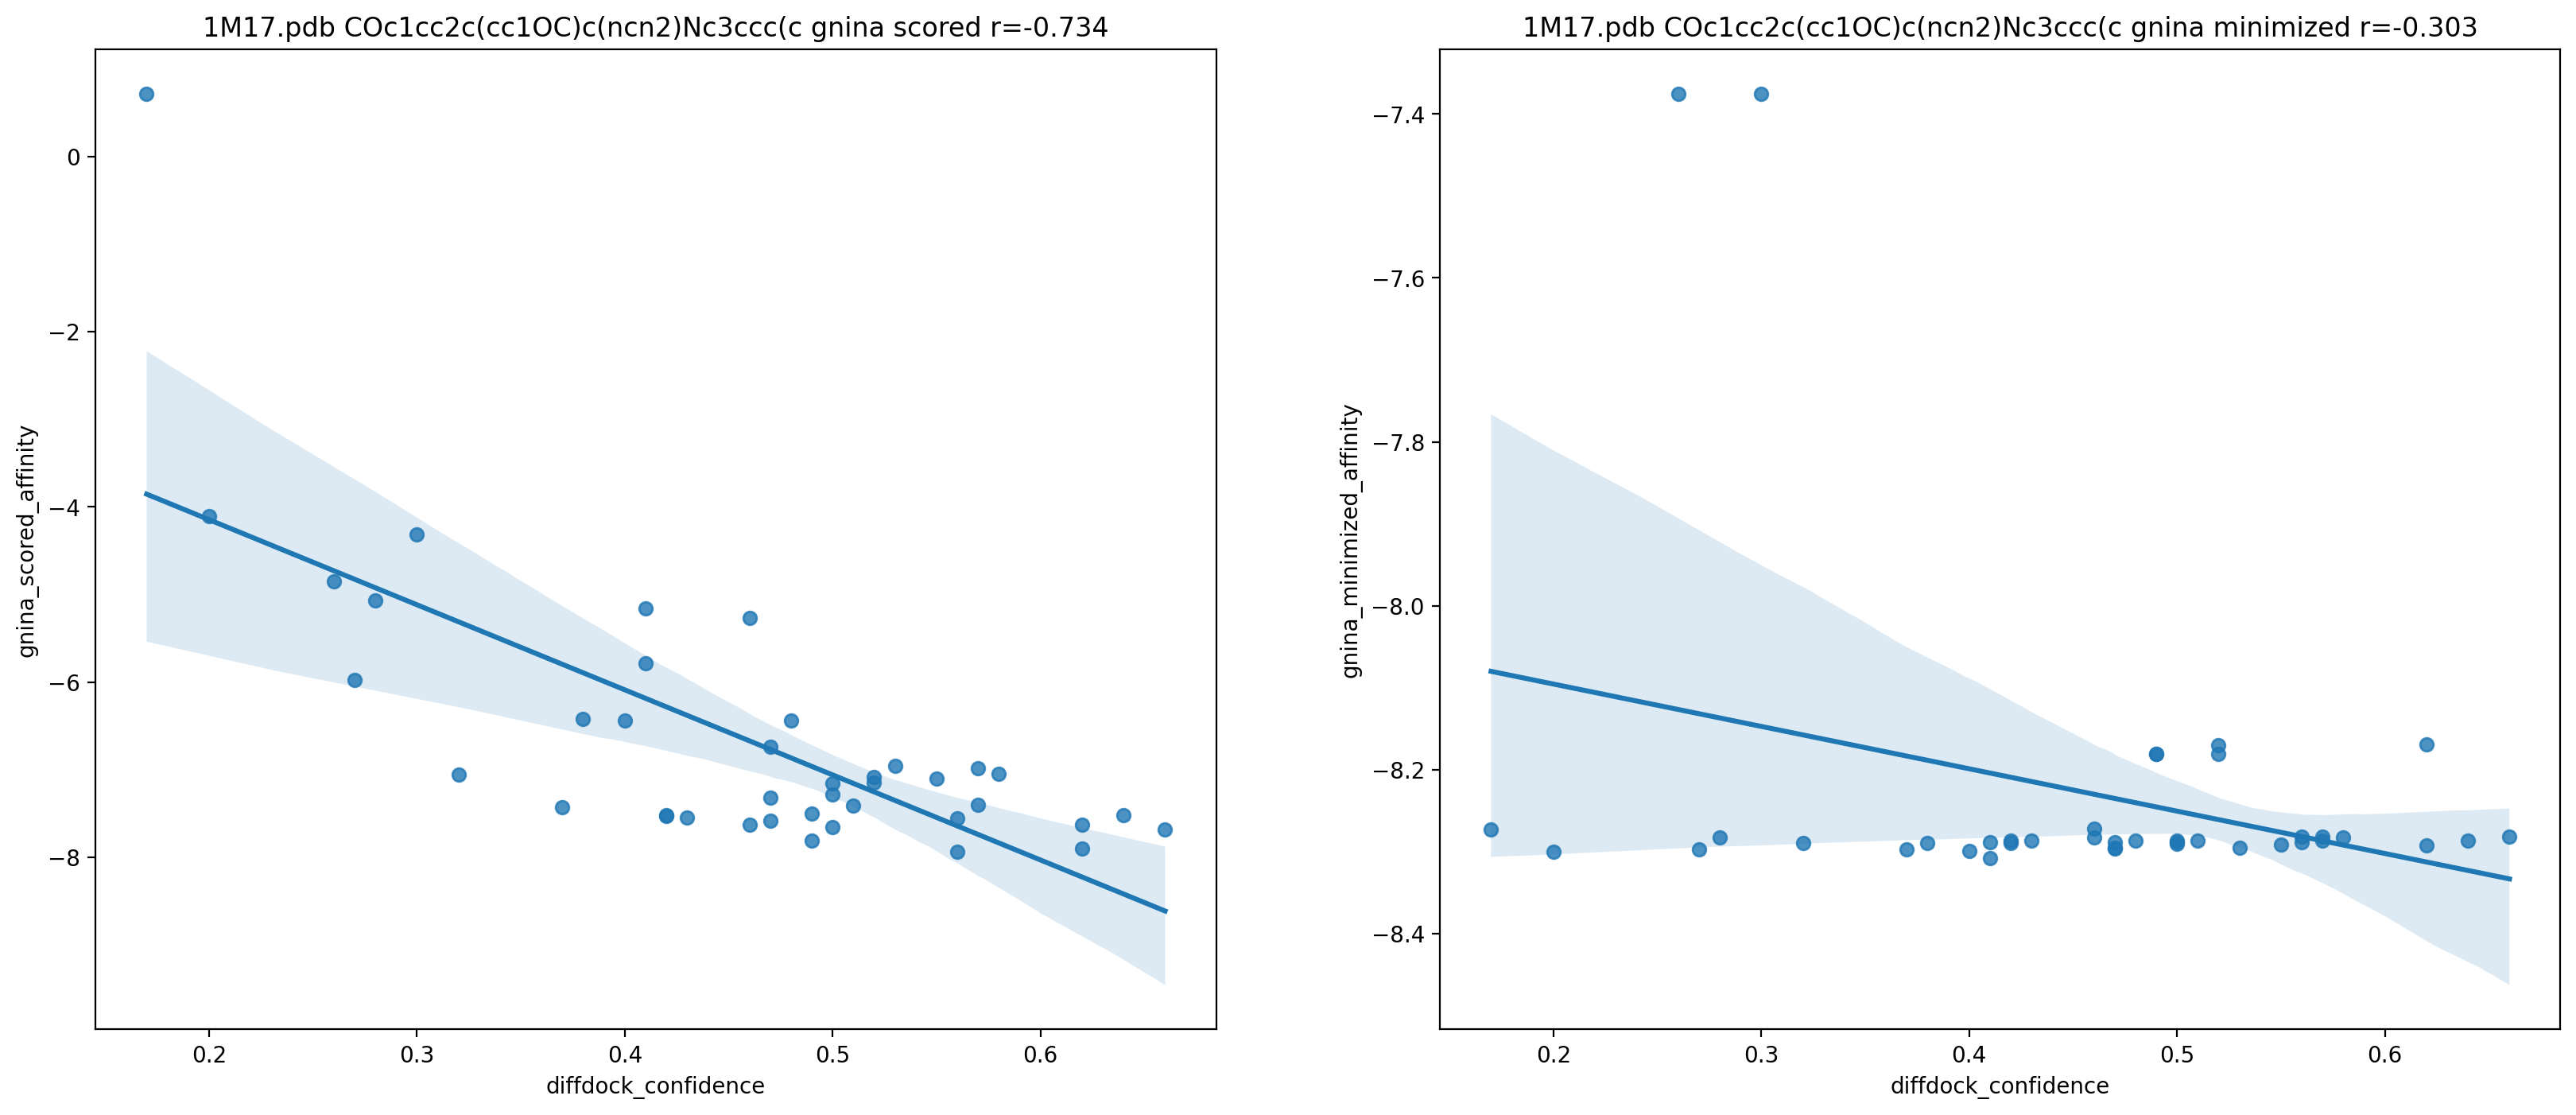

time: 1.37 s (started: 2026-01-11 13:27:15 +00:00)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
%config InlineBackend.figure_format='retina'

for (pdb_file, smiles), df_group in df_results.groupby(["pdb_file", "smiles"]):
    f, ax = plt.subplots(1, 2, figsize=(20,8))
    sns.regplot(data=df_group, x="diffdock_confidence", y="gnina_scored_affinity", ax=ax[0]);
    sns.regplot(data=df_group, x="diffdock_confidence", y="gnina_minimized_affinity", ax=ax[1]);

    slope, intercept, r_value_scored, p_value, std_err = linregress(df_group["diffdock_confidence"], df_group["gnina_scored_affinity"])
    slope, intercept, r_value_minimized, p_value, std_err = linregress(df_group["diffdock_confidence"], df_group["gnina_minimized_affinity"])
    ax[0].set_title(f"{pdb_file} {smiles[:30]} gnina scored r={r_value_scored:.3f}");
    ax[1].set_title(f"{pdb_file} {smiles[:30]} gnina minimized r={r_value_minimized:.3f}");

In [ ]:
df_results.sort_values("diffdock_confidence", ascending=False).head(3)

,pdb_file,smiles,diffdock_confidence,gnina_scored_affinity,gnina_minimized_affinity,sdf_file
29,1M17.pdb,COc1cc2c(cc1OC)c(ncn2)Nc3ccc(c(c3)Cl)F,0.66,-7.68229,-8.28215,./index0_-tmp-pdb-1M17.pdb____COc1cc2c(cc1OC)c...
37,1M17.pdb,COc1cc2c(cc1OC)c(ncn2)Nc3ccc(c(c3)Cl)F,0.64,-7.52163,-8.28651,./index0_-tmp-pdb-1M17.pdb____COc1cc2c(cc1OC)c...
34,1M17.pdb,COc1cc2c(cc1OC)c(ncn2)Nc3ccc(c(c3)Cl)F,0.62,-7.89533,-8.16949,./index0_-tmp-pdb-1M17.pdb____COc1cc2c(cc1OC)c...


time: 43.6 ms (started: 2026-01-11 13:27:16 +00:00)


# Visualize top hit (highest confidence) in 3D

In [ ]:
!pip install py3dmol==2.0.3 --quiet

time: 3.28 s (started: 2026-01-11 13:27:16 +00:00)


In [ ]:
from IPython.display import HTML
import py3Dmol

resid_hover = """
function(atom,viewer) {
    if(!atom.label) {
        atom.label = viewer.addLabel(atom.chain+" "+atom.resn+" "+atom.resi,
            {position: atom, backgroundColor: 'mintcream', fontColor:'black', fontSize:12});
    }
}"""
unhover_func = """
function(atom,viewer) {
    if(atom.label) {
        viewer.removeLabel(atom.label);
        delete atom.label;
    }
}"""

view = py3Dmol.view(width=800, height=800)
view.setCameraParameters({'fov': 35, 'z': 100});

# top hit for any pdb file and any smiles
top_hit = df_results.sort_values("diffdock_confidence", ascending=False).iloc[0]
print("top hit:")
display(top_hit)

# add sdf
view.addModel(open(top_hit.sdf_file).read(), "sdf")
view.setStyle({"model": 0}, {'stick':{"color":"#ff0000"}})
view.setViewStyle({"model": 0}, {'style':'outline','color':'black','width':0.1})
view.zoomTo();

# add pdb
view.addModel(open(top_hit.pdb_file).read(), "pdb");
view.setStyle({"model": 1}, {"cartoon":{"color":"spectrum"}})
view.setStyle({"model": 1, "hetflag":True}, {'stick':{"color":"spectrum"}})

model = view.getModel()
model.setHoverable({}, True, resid_hover, unhover_func)

view

top hit:


,29
pdb_file,1M17.pdb
smiles,COc1cc2c(cc1OC)c(ncn2)Nc3ccc(c(c3)Cl)F
diffdock_confidence,0.66
gnina_scored_affinity,-7.68229
gnina_minimized_affinity,-8.28215
sdf_file,./index0_-tmp-pdb-1M17.pdb____COc1cc2c(cc1OC)c...


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

time: 19.2 ms (started: 2026-01-11 13:27:19 +00:00)
